# Multilayer Perceptron (MLP)

In [ ]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [ ]:
DATA_ROOT = 'Data/LastOnlyProcessed'

In [ ]:
SAVE_DIR = 'Model'

In [ ]:
DATA_SIZE = 'full'   # choose one in {small, medium, full}
DATA_TYPE = 'mixed'   # choose one in {standard, mixed, minmax}

In [ ]:
TRAIN = True

In [ ]:
NUM_EPOCH = 200
EARLY_STOP = 20
HIDDEN_SIZE = 64
BATCH_SIZE = 128

In [ ]:
if DATA_SIZE == 'full':
    X_train = np.load(os.path.join(DATA_ROOT, 'full', f'X_train_{DATA_TYPE}.npy'))
    y_train = np.load(os.path.join(DATA_ROOT, 'full', 'y_train.npy'))
else:
    X_train = np.load(os.path.join(DATA_ROOT, DATA_SIZE, f'X_train_{DATA_TYPE}_{DATA_SIZE}.npy'))
    y_train = np.load(os.path.join(DATA_ROOT, DATA_SIZE, f'y_train_{DATA_SIZE}.npy'))

X_val = np.load(os.path.join(DATA_ROOT, 'full', f'X_val_{DATA_TYPE}.npy'))
y_val = np.load(os.path.join(DATA_ROOT, 'full', 'y_val.npy'))
X_test = np.load(os.path.join(DATA_ROOT, 'full', f'X_test_{DATA_TYPE}.npy'))
y_test = np.load(os.path.join(DATA_ROOT, 'full', 'y_test.npy'))

In [ ]:
X_train.shape

(250000, 59)

In [ ]:
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
X_val, y_val = torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

In [ ]:
class MLP(nn.Module):
    # constructor
    def __init__(self, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(59, hidden_size)
        # self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        # self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # x = self.fc2(x)
        # x = self.bn2(x)
        # x = F.relu(x)
        # x = self.dropout2(x)

        out = self.fc3(x)
        return out


In [ ]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    train_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.reshape(-1)
        loss = criterion(output, target)
        train_loss += loss.item()
        train_count += len(data)
        loss /= data.size(0)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= train_count
    return train_loss

In [ ]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    list_y_true = []
    list_y_score = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.reshape(-1)
            test_loss += criterion(output, target).item() # sum up batch loss

            list_y_true.extend(target.long().cpu().numpy().tolist())
            list_y_score.extend(torch.sigmoid(output).cpu().numpy().tolist())

    test_loss /= len(test_loader.dataset)
    auc = roc_auc_score(list_y_true, list_y_score)
    print('\nTest set: Average loss: {:.4f}, AUC: {:.4f}\n'.format(test_loss, auc))
    return test_loss, auc, list_y_score

In [ ]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

torch.manual_seed(123)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
y_train

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [ ]:
num_positive = torch.sum(y_train)
num_negative = len(y_train) - num_positive
pos_weight = 35 #num_negative / num_positive

In [ ]:
print(num_positive, num_negative, pos_weight)

tensor(7734.) tensor(242266.) 35


In [ ]:
model = MLP(HIDDEN_SIZE).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)  # Adam with weight
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
criterion = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.tensor(pos_weight)) # Use Binary Cross-Entropy with Logit Loss

In [ ]:
if TRAIN:
    os.makedirs(SAVE_DIR, exist_ok=True)
    best_val_auc = 0.0
    early_stop_counter = 0
    train_losses = []
    val_losses = []
    for epoch in range(1, NUM_EPOCH + 1):
        train_loss = train(model, device, train_loader, criterion, optimizer, epoch)
        train_losses.append(train_loss)
        val_loss, val_auc, _ = test(model, device, val_loader, criterion)
        val_losses.append(val_loss)
        scheduler.step(val_auc)

        if val_auc > best_val_auc:
            print(f"New Best Validation AUC: {val_auc} at epoch {epoch}\n")
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, "mlp_Sunyoung.pt"))
            best_val_auc = val_auc
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter == EARLY_STOP:
            break

# load the best model either it is train mode or not
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "mlp_Sunyoung.pt")))

Train Epoch: 1 [0/250000 (0%)]	Loss: 1.709940
Train Epoch: 1 [128000/250000 (51%)]	Loss: 1.031754

Test set: Average loss: 1.4123, AUC: 0.6362

New Best Validation AUC: 0.636193755739733 at epoch 1

Train Epoch: 2 [0/250000 (0%)]	Loss: 1.056190
Train Epoch: 2 [128000/250000 (51%)]	Loss: 1.475497

Test set: Average loss: 1.4124, AUC: 0.6396

New Best Validation AUC: 0.6396399969855002 at epoch 2

Train Epoch: 3 [0/250000 (0%)]	Loss: 1.592657
Train Epoch: 3 [128000/250000 (51%)]	Loss: 1.417324

Test set: Average loss: 1.4181, AUC: 0.6390

Train Epoch: 4 [0/250000 (0%)]	Loss: 0.773295
Train Epoch: 4 [128000/250000 (51%)]	Loss: 1.276969

Test set: Average loss: 1.4322, AUC: 0.6379

Train Epoch: 5 [0/250000 (0%)]	Loss: 0.861231
Train Epoch: 5 [128000/250000 (51%)]	Loss: 1.677523

Test set: Average loss: 1.4139, AUC: 0.6417

New Best Validation AUC: 0.6416958642894677 at epoch 5

Train Epoch: 6 [0/250000 (0%)]	Loss: 0.970570
Train Epoch: 6 [128000/250000 (51%)]	Loss: 1.175581

Test set: Aver

<All keys matched successfully>

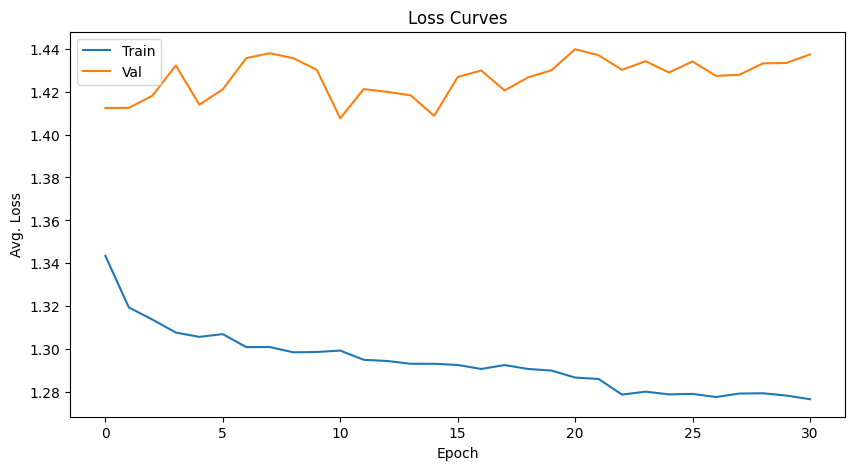

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Avg. Loss')
ax.set_title('Loss Curves')
plt.show()

In [ ]:
test_loss, test_auc, y_score = test(model, device, test_loader, criterion)


Test set: Average loss: 1.4158, AUC: 0.6327



In [ ]:
y_score = np.array(y_score)
y_pred = (y_score > 0.5).astype(int)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.58      0.73    483593
         1.0       0.05      0.61      0.09     16407

    accuracy                           0.58    500000
   macro avg       0.51      0.59      0.41    500000
weighted avg       0.95      0.58      0.71    500000



In [ ]:
f1_score(y_test, y_pred)

0.08736408443582676

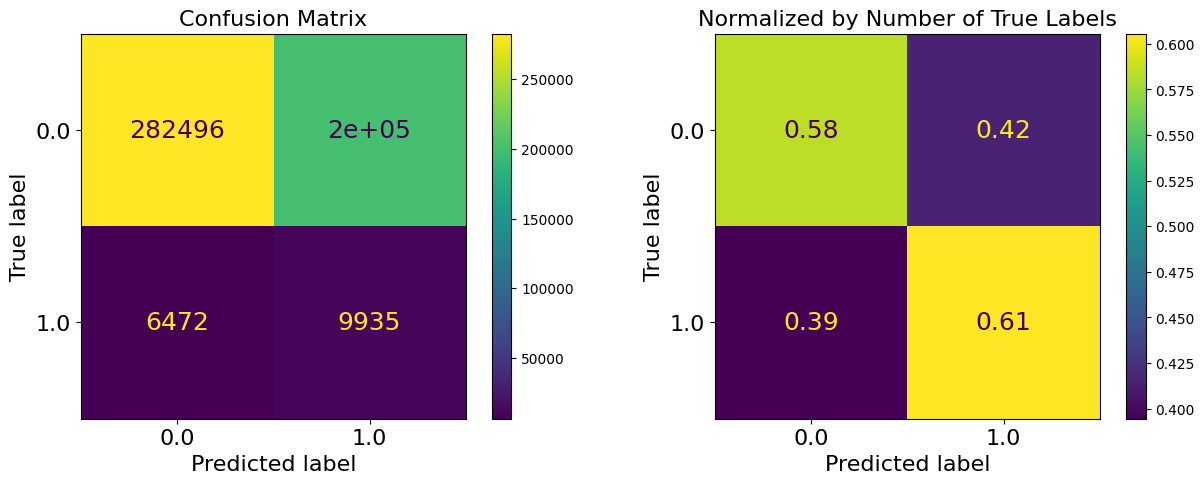

In [ ]:
fig1, (ax11, ax12) = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax11, text_kw={'fontsize': 18})
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', ax=ax12, text_kw={'fontsize': 18})
ax11.set_title('Confusion Matrix', fontsize=16)
ax12.set_title('Normalized by Number of True Labels', fontsize=16)
ax11.xaxis.label.set_fontsize(16)
ax11.yaxis.label.set_fontsize(16)
ax11.tick_params(axis='both', which='major', labelsize=16)
ax12.xaxis.label.set_fontsize(16)
ax12.yaxis.label.set_fontsize(16)
ax12.tick_params(axis='both', which='major', labelsize=16)
plt.show()

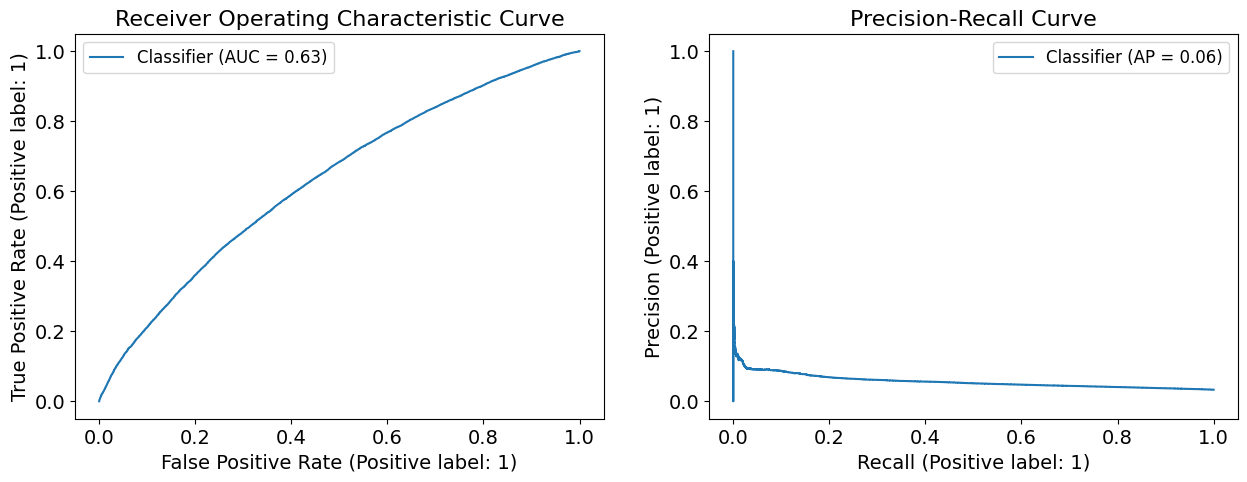

In [ ]:
fig2, (ax21, ax22) = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_predictions(y_test, y_score, ax=ax21)
PrecisionRecallDisplay.from_predictions(y_test, y_score, ax=ax22)
ax21.set_title('Receiver Operating Characteristic Curve', fontsize=16)
ax21.xaxis.label.set_fontsize(14)
ax21.yaxis.label.set_fontsize(14)
ax21.tick_params(axis='both', which='major', labelsize=14)
ax21.legend(fontsize=12)
ax22.set_title('Precision-Recall Curve', fontsize=16)
ax22.xaxis.label.set_fontsize(14)
ax22.yaxis.label.set_fontsize(14)
ax22.tick_params(axis='both', which='major', labelsize=14)
ax22.legend(fontsize=12)
plt.show()